In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as ssp
import scipy.linalg as salg
from scipy.sparse.linalg import spsolve, splu
from collections.abc import Callable
from sksparse.cholmod import cholesky

In [113]:
#Defining the constants
P = 2		#Power of two
N = 2**P	#Number of subdivisions
U0 = 0.01 	#The border constant we might need to use?
h = 1/N		#Discretisation step

DEBUG = True

In [114]:

def get_elem_mat(N: int, dimension: str) -> ssp.csr_matrix:
	"""Creates the element matrix 'Ah' for the 2D or 3D discrete laplaciaan

	Parameters
	----------
	N : int
	    Number of points in a direction of the grid
	dimension : str
	    2D/3D for two/three-dimensional discrete laplacian

	Returns
	-------
	ssp.csc_matrix
	    The element matrix Ah
	"""	
	one_dim_diff = 2*np.eye((N))-np.eye((N), k=-1)-np.eye((N), k=1)


	ONE_DIM_DIFF	= ssp.csr_matrix(one_dim_diff.astype(int))
	ID 		= ssp.csr_matrix(np.eye(N).astype(int))

	x_dim_diff = (1/(h**2) * ssp.kron(ONE_DIM_DIFF,ID))
	y_dim_diff = (1/(h**2) * ssp.kron(ID, ONE_DIM_DIFF))

	X_DIM_DIFF 	= ssp.csr_matrix(x_dim_diff.astype(int))
	Y_DIM_DIFF 	= ssp.csr_matrix(y_dim_diff.astype(int))
	TWO_LAPLACE 	= ssp.csr_matrix(x_dim_diff + y_dim_diff)

	one_dim_diff = None
	x_dim_diff = None
	y_dim_diff = None

	if dimension == "2D":
		return TWO_LAPLACE

	elif dimension == "3D":	
		z_dim_diff = (1/(h**2)*(
			ssp.kron(ID,
				ssp.kron(ID, ONE_DIM_DIFF)
				)
			)
		)

		Z_DIM_DIFF 	= ssp.csr_matrix(z_dim_diff.astype(int))
		z_dim_diff = None

		THREE_LAPLACE = (ssp.kron(X_DIM_DIFF, ID) 
				+ssp.kron(Y_DIM_DIFF, ID)
				+Z_DIM_DIFF)
		
		return THREE_LAPLACE

	else:
		raise ValueError('string: Dimension, either "2D" or "3D"')


In [115]:
def build_forcing_vector(lin_spaces: list,
			 internal_fun,
			 boundary_fun  = None
			 ) -> np.ndarray:
	"""Builds the RHS of the linear system for a arbitray-dimensional laplacian

	Parameters
	----------
	lin_spaces : list
	    List of arrays of points that will be used to build the meshgrid
	internal_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that coordinate
	boundary_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that boundary coordinate

	Returns
	-------
	np.ndarray
	    The forcing vector
	"""	
	grids = np.meshgrid(*lin_spaces)
	internal_forcing_array = internal_fun(*grids)
	if boundary_fun == None:
		def boundary_fun(*grids):
			return 0*grids[0]
			
	boundary_forcing_array = boundary_fun(*grids)

	dims = len(lin_spaces)
	mask = tuple([slice(1,-1)]*dims)
	forcing, forcing[mask] = boundary_forcing_array, internal_forcing_array[mask]
	print(mask)

	forcing_vector = forcing.flatten()
	return forcing_vector


In [116]:
%%time

def int_forc_fun(x,y):
	return (x**2 + y**2)*np.sin(x*y)

def bound_forc_fun(x,y):
	return np.sin(x*y)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

X, Y = np.meshgrid(x,y)

CPU times: user 546 µs, sys: 145 µs, total: 691 µs
Wall time: 476 µs


In [117]:
vecF = build_forcing_vector([x,y], int_forc_fun, bound_forc_fun)

(slice(1, -1, None), slice(1, -1, None))


In [118]:
%%time
TWO_LAPLACE = get_elem_mat(N+1, "2D")

CPU times: user 6.3 ms, sys: 0 ns, total: 6.3 ms
Wall time: 3.86 ms


In [119]:
%%time
#Manipulating the 2D-laplacian and the forcing vector to obey boundary elements
#By selecting the boundary points
Xval, Yval = X.ravel(), Y.ravel()

boundary_list = np.squeeze(
	np.where(
		(Xval==x[0]) | (Xval==x[-1]) | (Yval==y[0]) | (Yval==y[-1])
	)
);

SPARSE_ID = ssp.eye((N+1)**2).tocsr()
for row in boundary_list:
	TWO_LAPLACE[row,:] = SPARSE_ID[row,:]
SPARSE_ID = None



CPU times: user 8.78 ms, sys: 0 ns, total: 8.78 ms
Wall time: 6.42 ms


In [120]:
size = (N+1)**2

TWO_LAPLACE = TWO_LAPLACE.tocsc()
P_MATRIX = ssp.csc_matrix((size,size))


TWO_LAPLACE.shape


(25, 25)

In [121]:
ONES = ssp.csr_matrix((size,size))
ONES[boundary_list,boundary_list] = 1


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [122]:
%%time

ZEROES = ssp.csc_matrix((size,size))

for column in boundary_list:
	P_MATRIX[:, column] = TWO_LAPLACE[:, column]
	TWO_LAPLACE[:,column] = ZEROES[:,column]

print(type(TWO_LAPLACE))

TWO_LAPLACE = (TWO_LAPLACE + ONES)
P_MATRIX = (P_MATRIX - ONES)

print(type(TWO_LAPLACE))

<class 'scipy.sparse.csc.csc_matrix'>
<class 'scipy.sparse.csc.csc_matrix'>
CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 15.6 ms


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [123]:
pm = P_MATRIX

In [124]:
P_MATRIX.shape

(25, 25)

In [125]:
#Building u0
U0 = np.sin(X*Y)
u0 = U0.flatten()
to_subtract = P_MATRIX.dot(u0)


In [126]:
vecF = np.subtract(vecF, to_subtract)

In [127]:
TWO_LAPLACE.shape

(25, 25)

In [128]:
%%time
u = spsolve(TWO_LAPLACE, vecF.T)

CPU times: user 1.13 ms, sys: 300 µs, total: 1.43 ms
Wall time: 722 µs


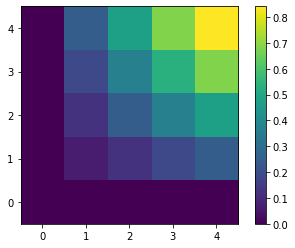

In [129]:
array_u = u.reshape((N+1,N+1))
plt.imshow(array_u, origin='lower');
plt.colorbar()

In [130]:
u_ex = np.sin(X*Y)
vec_u_ex = u_ex.flatten()

In [131]:
error = np.sqrt(h**2 *np.sum((vec_u_ex-u)**2))
print("h**2: {:.5f}\t error: {:.5f}".format(h**2, error))
print('relative error: {:.4f}\t [h**2]'.format(error/(h**2)))

h**2: 0.06250	 error: 0.00002
relative error: 0.0003	 [h**2]


In [132]:
def decomp_lu(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower matrix of the LU decomposition of M

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix to LU decompose such that L@U = M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower matrix L
	"""
	#In this code block all fully uppercase variables are sparse matrices
	shape_m = M.shape
	ID = ssp.eye(shape_m[0])
	ZEROES = ssp.csc_matrix(shape_m)

	SUM = ID.copy()
	for k in range(0, shape_m[1]):
		Akk = M[k,k]
		VEC = M[:,k] / Akk
		VEC[0: k+1] = ZEROES[0:k+1, 0]

		EK = ZEROES[:,0].copy()
		EK[k] = 1

		ADD = VEC * EK.T
		SUM += ADD
		
	return SUM

In [133]:
from tqdm import tqdm

In [134]:
##Mocht je hier een error krijgen dan moet je waarschijnlijk even het volgende veranderen
## tqdm(range(...)) -> range(...)


def decomp_cholesky(M: ssp.csc_matrix) -> ssp.csc_matrix:
	"""Creates the sparse lower triangular matrix C that results from cholesky
	decomposition.

	Parameters
	----------
	M : ssp.csc_matrix
	    The matrix M such that cholesky decomposition yields C, scuh that 
	    C@C.T == M

	Returns
	-------
	ssp.csc_matrix
	    The sparse lower triangular matrix C
	"""	
	shape_m = M.shape
	ZEROES = ssp.lil_matrix(shape_m)
	C = ssp.lil_matrix(shape_m)
	TMP = M.copy().tolil()

	for col in tqdm(range(0, shape_m[1])): #Hierzo
		C[col,col] = np.sqrt((TMP[col,col] - ( C[col,0:col].power(2) ).sum()))
		TMP[col,col] = C[col,col]

		PROD = TMP[col+1:,0:col]*TMP[col,0:col].T

		SUM = PROD.sum(axis=1)

		pref = 1/(C[col,col])

		C[col+1:,col] = pref*(TMP[col+1:,col] - SUM)
		TMP[col+1:,col] = C[col+1:, col]

		C[col,col+1:] = ZEROES[col,col+1:]

	return C


In [135]:
TWO_LAPLACE.tocsc()

<25x25 sparse matrix of type '<class 'numpy.float64'>'
	with 49 stored elements in Compressed Sparse Column format>

In [136]:
%%time
##Mocht je een error krijgen, lees dan de comment in de cell hierboven
C = decomp_cholesky(TWO_LAPLACE)

100%|██████████| 25/25 [00:00<00:00, 633.54it/s]

CPU times: user 37.2 ms, sys: 12.2 ms, total: 49.5 ms
Wall time: 42 ms


In [138]:
%%time

C_factor = cholesky(TWO_LAPLACE, beta=0, ordering_method='natural')


CPU times: user 58 µs, sys: 15 µs, total: 73 µs
Wall time: 76.1 µs


In [139]:
C2 = C_factor.L()

In [140]:
np.alltrue(C.toarray() == C2.toarray())

False

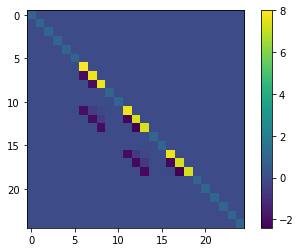

In [141]:
plt.close()
plt.imshow(C2.toarray())
plt.colorbar()

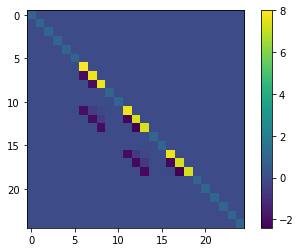

In [142]:
plt.imshow(C.toarray())
plt.colorbar()

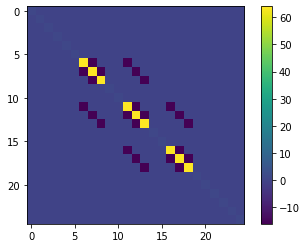

In [143]:
PLZ_WORK = C@C.T
plt.imshow(PLZ_WORK.toarray())
plt.colorbar()

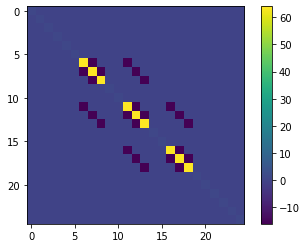

In [144]:
MAYBE = C2@C2.T
plt.imshow(MAYBE.toarray())
plt.colorbar()

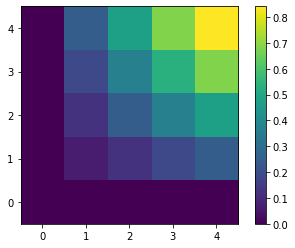

In [145]:
U_MAYBE = spsolve(MAYBE, vecF)

u_maybe = (U_MAYBE).reshape((N+1,N+1))
plt.imshow(u_maybe, origin='lower')
plt.colorbar()

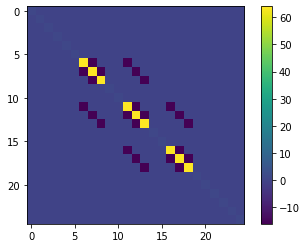

In [146]:
plt.imshow(TWO_LAPLACE.toarray())
plt.colorbar()

In [147]:
def sys_solve_chol(f: ssp.csc_matrix, C: ssp.csc_matrix) -> ssp.csc_matrix:
	LOWER = C
	UPPER = C.T
	b = spsolve(LOWER, f)
	sol = spsolve(UPPER, b)

	return sol


In [148]:
%%time

u = sys_solve_chol(vecF, C)

CPU times: user 2.49 ms, sys: 660 µs, total: 3.15 ms
Wall time: 1.93 ms


/home/jeroensangers/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


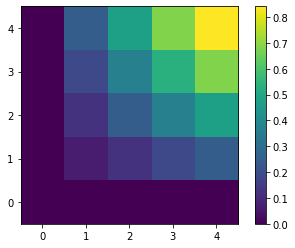

In [149]:
array_u = u.reshape((N+1,N+1))

plt.imshow(array_u, origin='lower')
plt.colorbar()